# Network Flow Problem: Maximum flow

In [1]:
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import gurobipy as gp 
from gurobipy import GRB


np.random.seed(2023)

In [2]:
# generate the problem

n = 9
c = np.array([4, 4, 2, 2, 6, 1, 3, 2, 1])

# equality constraints
m = 5
B = np.zeros((m, n))
B[0,0], B[0,1] = 1, 1
B[1,:] = np.array([-1, 0, 1, 1, 1, 0, 0, 0, 0])
B[2,:] = np.array([0, -1, -1, 0, 0, 1, 1, 0, -1])
B[m-2,:] = np.array([0, 0, 0, -1, 0, -1, 0, 1, 0])
B[m-1,:] = np.array([0, 0, 0, 0, -1, 0, -1, -1, 1])
d = np.array([20, 0, 0, -5, -15])

# inequality constraints
p = 16
A = np.zeros((p, n))
A[:n, :n] = -np.eye(n)
A[-7, 0], A[-6, 1], A[-5, 3], A[-4, 4], A[-3, 5], A[-2, 6], A[-1, 8] = 1, 1, 1, 1, 1, 1, 1, 
b = np.zeros(p)
b[-7], b[-6], b[-5], b[-4], b[-3], b[-2], b[-1] = 15, 8, 4, 10, 15, 5, 4
tim = 300
step = 10000
time_step = np.linspace(0,tim,step)

print(B, d, A, b)

[[ 1.  1.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  1.  1.  1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  1.  1.  0. -1.]
 [ 0.  0.  0. -1.  0. -1.  0.  1.  0.]
 [ 0.  0.  0.  0. -1.  0. -1. -1.  1.]] [ 20   0   0  -5 -15] [[-1. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -1. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -1. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -1. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -1. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -1. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -1. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -1. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0. -1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.]] [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 15.  8.  4. 10. 15.  5.  4.]


In [3]:
def dx(vector, t, n, m, rho, p, B, d, A, b, c):
    x, x_bar, y, y_bar, z, z_bar = vector[0:n], vector[n:2*n], vector[2*n:2*n+m], vector[2*n+m:2*n+2*m], vector[2*n+2*m:2*n+2*m+p], vector[2*n+2*m+p:]

    dx = -c -B.T@y - A.T@z - rho*(x-x_bar)
    dx_bar = rho*(x-x_bar)
    dy = B@x - d - rho*(y-y_bar)
    dy_bar = rho*(y-y_bar)
    dz = A@x - b - rho*(z-z_bar)
    dz_bar = rho*(z-z_bar)

    for i in range(p):
        if z[i]<=0: dz[i] = np.max([0, dz[i]])
    dynamics = np.concatenate((dx, dx_bar, dy, dy_bar, dz, dz_bar)).reshape(2*n+2*m+2*p,).tolist()
    return dynamics

In [4]:
# compute the optimal solution to the equivalent form of Lasso regression problem
def gurobi_lasso(n, m, p, B, d, A, b, c):
    dim = n
    model = gp.Model("LP")
    model.setParam('OutputFlag', 0) 
    x = model.addMVar(dim, name='x')

    obj = c.T@x
    # set objective
    model.setObjective(obj, GRB.MINIMIZE)
    # set constraints
    # equality constraints
    model.addConstr(B@x == d)
    # inequality constraints
    model.addConstr(A@x <= b)

    model.update()
    model.optimize()

    x_opt = np.zeros(n)
    v_opt = np.zeros(m+p)
    if model.status == GRB.OPTIMAL:
        # Access the optimal variable values
        for i in range(dim):
            x_opt[i] = model.getVarByName('x[{}]'.format(i)).X
    else:
        print("Optimization did not converge to an optimal solution.")
    flag = 0
    for con in model.getConstrs():
        v_opt[flag] = - con.Pi
        flag += 1
    return x_opt, v_opt

x_opt, v_opt = gurobi_lasso(n, m, p, B, d, A, b, c)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-19


In [5]:
x0 = np.zeros(2*n+2*m+2*p)
x0[:n] = np.random.rand(n)
# rho_list = [0.01, 0.05, 0.1, 0.5, 1]
rho_list = [0.05]
res = {}
for rho in rho_list:
    res[rho] = odeint(dx, x0, time_step, args=(n, m, rho, p, B, d, A, b, c))
    res_t = res[rho]
    print('Our Solution:', res_t[-1,:n])
    print('Our Dual Variables', res_t[-1, 2*n:2*n+m], res_t[-1, 2*n+2*m:2*n+2*m+p])
    print('Gurobi Solution:', x_opt)
    print('Gurobi Dual Variables', v_opt)

Our Solution: [ 1.20000015e+01  8.00000200e+00  8.00000127e+00  3.99999996e+00
 -2.70373967e-07  1.10003418e+01  4.99965987e+00  1.00003413e+01
 -2.42356633e-10]
Our Dual Variables [-5.20000036 -1.19999973  0.80000034  1.79999932  3.80000042] [-6.59874623e-08 -8.70315806e-09 -3.44215569e-09 -7.09714464e-11
  1.00000054e+00  0.00000000e+00 -6.57137737e-09  0.00000000e+00
  3.99999981e+00 -1.12770760e-09  1.99999938e+00  9.99999797e-01
  0.00000000e+00  0.00000000e+00 -5.32246513e-09 -2.83268202e-09]
Gurobi Solution: [12.  8.  8.  4.  0. 11.  5. 10.  0.]
Gurobi Dual Variables [-9. -5. -3. -2. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  2.  1. -0.
 -0. -0. -0.]


In [6]:
import pickle
import datetime
now = datetime.datetime.now()
# Pickling the object
Storage = {'result':res, 'x_opt':x_opt, 'v_opt':v_opt, 'time_step':time_step, 'rho_list':rho_list, 'n':n, 'm':m, 'p':p, 'B':B, 'd':d, 'A':A, 'b':b, 'c':c}
today = now.strftime("%Y-%m-%d")
root = 'LP_results_{}_parameters.pkl'.format(today)
with open(root, 'wb') as file:
    pickle.dump(Storage, file)

In [7]:
import pickle
import datetime
# Unpickling the object
with open(root, 'rb') as file:
    loaded_object = pickle.load(file)

result = loaded_object['result']
rho_list = loaded_object['rho_list']
x_opt = loaded_object['x_opt']
time_step = loaded_object['time_step']

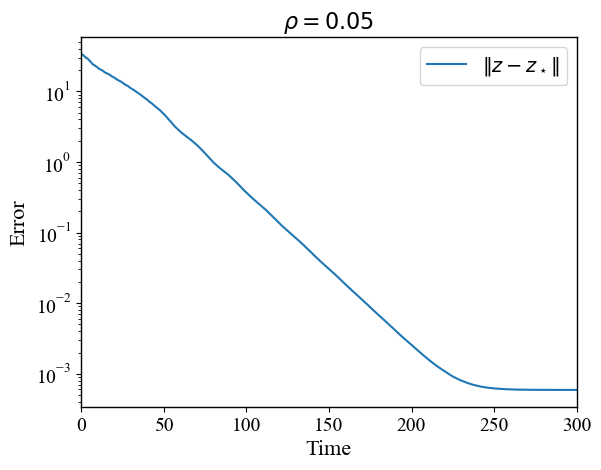

In [8]:
for rho in rho_list:
    plt.figure()
    res = result[rho]
    t = len(time_step)
    # print('Our Solution:', res[-1,:n])
    # print('Our Dual Variables', res[-1, 2*n:2*n+m], res[-1, 2*n+2*m:2*n+2*m+p])
    # print('Gurobi Solution:', x_opt)
    # print('Gurobi Dual Variables', v_opt)
    opt = np.concatenate((x_opt, res[-1][n:]))
    plt.plot(time_step[:t],np.linalg.norm(res[:t]-opt[:t],axis=1))
    # plt.plot(time_step,np.linalg.norm(res[:,:n]-x_opt,axis=1))
    plt.yscale("log")
    plt.margins(x=0)
    # legend = ['$\\|x-x_\star\\|$', '$\\|y-y_\star\\|$']
    legend = ['$\\|z-z_\star\\|$']
    font = {'family':'Times New Roman', 'size':14}
    plt.legend(legend,prop=font)
    plt.xlabel('Time', font={'family':'Times New Roman', 'size':16})
    plt.ylabel('Error', font={'family':'Times New Roman', 'size':16})
    plt.xticks(fontproperties = 'Times New Roman', size = 14)
    plt.yticks(fontproperties = 'Times New Roman', size = 14)
    plt.title('$\\rho={}$'.format(rho), font={'family':'Times New Roman', 'size':16})
    #设置图框线粗细
    bwith = 1#边框宽度设置为2
    TK = plt.gca()#获取边框
    TK.spines['bottom'].set_linewidth(bwith)
    TK.spines['left'].set_linewidth(bwith)
    TK.spines['top'].set_linewidth(bwith)
    TK.spines['right'].set_linewidth(bwith)
    now = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    # plt.savefig('./Fig/{}_small_error_x_{}_.pdf'.format(now,time),dpi=1200)
    plt.show()

[ 1.20000015e+01  8.00000200e+00  8.00000127e+00  3.99999996e+00
 -2.70373967e-07  1.10003418e+01  4.99965987e+00  1.00003413e+01
 -2.42356633e-10  1.19999993e+01  7.99999610e+00  8.00000475e+00
  3.99999635e+00 -5.14941627e-07  1.10003433e+01  4.99966016e+00
  1.00003401e+01  2.21050242e-06 -5.20000036e+00 -1.19999973e+00
  8.00000343e-01  1.79999932e+00  3.80000042e+00 -5.20000354e+00
 -1.20000226e+00  7.99999468e-01  1.80000179e+00  3.80000453e+00
 -6.59874623e-08 -8.70315806e-09 -3.44215569e-09 -7.09714464e-11
  1.00000054e+00  0.00000000e+00 -6.57137737e-09  0.00000000e+00
  3.99999981e+00 -1.12770760e-09  1.99999938e+00  9.99999797e-01
  0.00000000e+00  0.00000000e+00 -5.32246513e-09 -2.83268202e-09
 -6.59548379e-08 -7.95332650e-10  3.83956767e-10  9.66737327e-09
  9.99989231e-01  0.00000000e+00 -6.29332419e-09  0.00000000e+00
  4.00000426e+00  1.37200647e-07  2.00000175e+00  1.00000293e+00
  0.00000000e+00  0.00000000e+00  4.49048002e-06  3.61509655e-08]


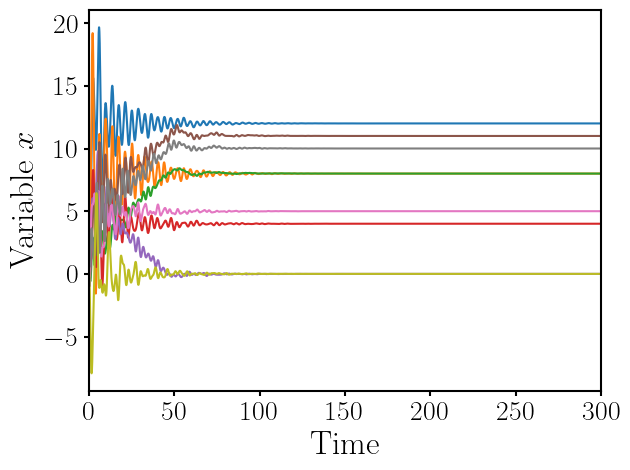

In [9]:
# 更新全局参数
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.weight": "bold"
})
rho_list = [0.05]
for rho in rho_list:
    plt.figure()
    res = result[rho]
    t = int(1.0*len(time_step))
    # opt = np.concatenate((x_opt, res[-1][n:]))
    print(res[-1])
    plt.plot(time_step[:t],res[:t,:n])
    # plt.plot(time_step,np.linalg.norm(res[:,:n]-x_opt,axis=1))
    # plt.yscale("log")
    plt.margins(x=0)
    plt.tick_params(width=1.5)
    legend = ['$\\|x-x_\star\\|$', '$\\|y-y_\star\\|$']
    legend = [r'$x_{12}$', r'$x_{13}$', r'$x_{23}$', r'$x_{24}$', r'$x_{25}$', r'$x_{35}$', r'$x_{43}$', r'$x_{35}$', r'$x_{53}$']
    legendfont = {'family':'Times New Roman', 'size':20, 'weight':'bold'}
    # plt.legend(legend,prop=legendfont,loc='upper right')
    plt.xlabel('Time', font={'family':'Times New Roman', 'size':24})
    plt.ylabel('Variable '+r'$x$', font={'family':'Times New Roman','size':24})
    plt.xticks(fontproperties = 'Times New Roman', size = 20)
    plt.yticks(fontproperties = 'Times New Roman', size = 20)
    # plt.title('Variables', font={'family':'Times New Roman', 'size':16})
    #设置图框线粗细
    bwith = 1.5#边框宽度设置为2
    TK = plt.gca()#获取边框
    TK.spines['bottom'].set_linewidth(bwith)
    TK.spines['left'].set_linewidth(bwith)
    TK.spines['top'].set_linewidth(bwith)
    TK.spines['right'].set_linewidth(bwith)

    plt.tight_layout()  # 自动调整子图参数以适应图形区域
    now = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    plt.savefig('./Fig/{}_small_primal_x_{}_.pdf'.format(now,time),dpi=1200)
    plt.show()

/var/folders/q6/7b2sl_vj4xn24xnpyjnw7h9r0000gn/T/ipykernel_72991/2778908754.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  TK.set_xticklabels(xticks, fontproperties='Times New Roman', size=20, weight='bold')
/var/folders/q6/7b2sl_vj4xn24xnpyjnw7h9r0000gn/T/ipykernel_72991/2778908754.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  TK.set_yticklabels(yticks, fontproperties='Times New Roman', size=20, weight='bold')


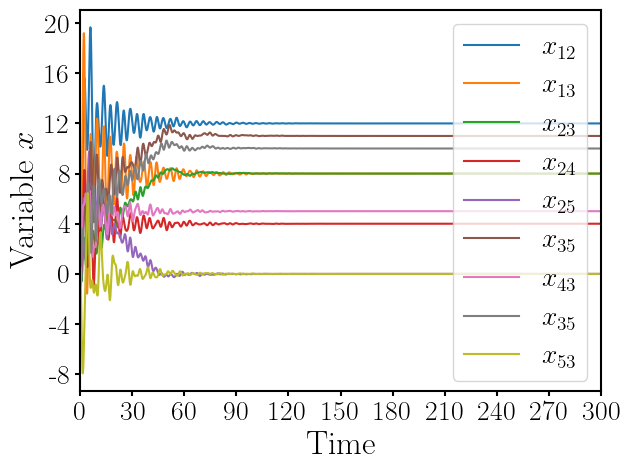

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import time

# 更新全局参数
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.weight": "bold"
})

rho_list = [0.05]
for rho in rho_list:
    fig, ax = plt.subplots()
    res = result[rho]
    t = int(1.0 * len(time_step))
    
    # 设置边距
    ax.margins(x=0)
    
    # 设置刻度线宽
    ax.tick_params(width=1.5)
    
    # 设置x轴和y轴标签
    ax.set_xlabel('Time', fontdict={'family': 'Times New Roman', 'size': 24})
    ax.set_ylabel('Variable '+r'${x}$', fontdict={'family': 'Times New Roman', 'size': 24})
    
    # 设置x轴和y轴刻度
    ax.tick_params(axis='x', width=1.5)
    ax.tick_params(axis='y', width=1.5)
    
    # 设置图框线粗细
    bwith = 1.5  # 边框宽度设置为1.5
    for spine in ax.spines.values():
        spine.set_linewidth(bwith)
    #设置图框线粗细
    bwith = 1.5#边框宽度设置为2
    TK = plt.gca()#获取边框
    TK.spines['bottom'].set_linewidth(bwith)
    TK.spines['left'].set_linewidth(bwith)
    TK.spines['top'].set_linewidth(bwith)
    TK.spines['right'].set_linewidth(bwith)
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()
    TK.set_xticklabels(xticks, fontproperties='Times New Roman', size=20, weight='bold')
    TK.set_yticklabels(yticks, fontproperties='Times New Roman', size=20, weight='bold')
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

    # 绘图
    ax.plot(time_step[:t], res[:t, :n])
    # ax.plot(time_step, np.linalg.norm(res[:,:n]-x_opt, axis=1))
    # ax.set_yscale("log")
    # 设置图例
    legend = ['$\\|x-x_\star\\|$', '$\\|y-y_\star\\|$']
    legend = [r'$x_{12}$', r'$x_{13}$', r'$x_{23}$', r'$x_{24}$', r'$x_{25}$', r'$x_{35}$', r'$x_{43}$', r'$x_{35}$', r'$x_{53}$']
    legendfont = {'family': 'Times New Roman', 'size': 20, 'weight': 'bold'}
    ax.legend(legend, prop=legendfont, loc='upper right') 

    # 自动调整子图参数以适应图形区域
    plt.tight_layout()
    
    # 保存图形
    now = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    plt.savefig('./Fig/{}_small_primal_x_{}_.pdf'.format(now, time), dpi=1200)
    
    plt.show()